In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x = np.linspace(0,40,400)

In [3]:
y = np.sin(x)

In [4]:
df = pd.DataFrame(data=y, index=x, columns=["sine"])

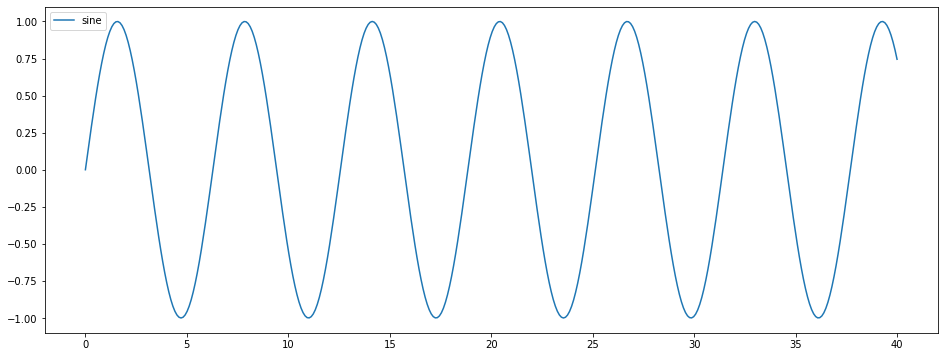

In [5]:
df.plot(figsize = (16,6))

In [6]:
test_percent = 0.1

In [7]:
test_size = round(len(df) * test_percent)

In [8]:
test_size

40

In [9]:
test_index = len(df) - test_size

In [10]:
test_index

360

In [11]:
train = df.iloc[:test_index]

In [12]:
len(train)

360

In [13]:
test = df.iloc[test_index:]

In [14]:
len(test )

40

### Scaling the data

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scalar = MinMaxScaler()

In [17]:
train_scaled = scalar.fit_transform(train)

In [18]:
test_scaled = scalar.transform(test)

### Time Series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [83]:
length = 50
batch = 1

In [84]:
generator = TimeseriesGenerator(
    train_scaled,
    train_scaled,
    length = length,
    batch_size=batch,

)

In [85]:
len(generator)

310

In [86]:
X, y = generator[0]

In [87]:
X

array([[[0.50000037],
        [0.55004181],
        [0.59958075],
        [0.64811972],
        [0.69517131],
        [0.74026304],
        [0.7829421 ],
        [0.82277993],
        [0.85937648],
        [0.89236426],
        [0.921412  ],
        [0.94622803],
        [0.96656314],
        [0.98221313],
        [0.99302085],
        [0.99887777],
        [0.99972507],
        [0.99555426],
        [0.9864072 ],
        [0.97237576],
        [0.95360082],
        [0.93027094],
        [0.90262038],
        [0.87092679],
        [0.83550845],
        [0.79672101],
        [0.75495397],
        [0.71062675],
        [0.66418446],
        [0.61609347],
        [0.5668367 ],
        [0.51690878],
        [0.46681106],
        [0.41704663],
        [0.3681152 ],
        [0.32050813],
        [0.27470347],
        [0.2311612 ],
        [0.19031856],
        [0.15258566],
        [0.11834143],
        [0.08792973],
        [0.06165595],
        [0.03978392],
        [0.02253329],
        [0

In [88]:
y

array([[0.02235272]])

In [89]:
train_scaled[50]

array([0.02235272])

In [90]:
len(train_scaled)

360

In [91]:
n_features = 1

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [93]:
model = Sequential()
model.add(SimpleRNN(units = 50, input_shape = (length,n_features), activation = "relu"))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

In [94]:
model.fit_generator(generator, epochs=3)

Epoch 1/3
  3/310 [..............................] - ETA: 8:44 - loss: 0.0513

KeyboardInterrupt: 

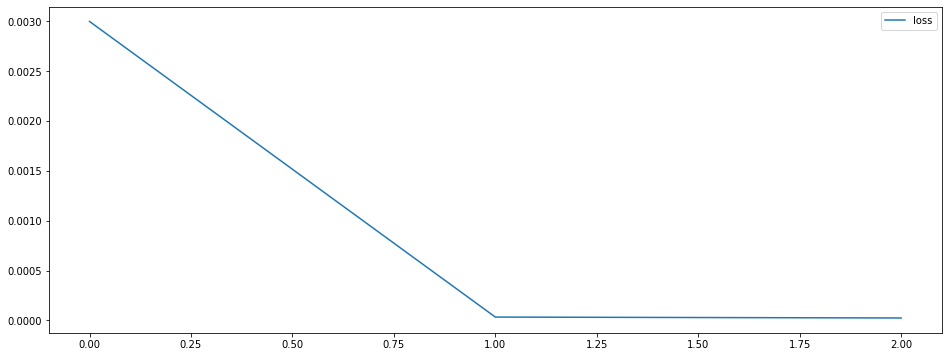

In [34]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

In [35]:
### Predictions

In [36]:
test_predictions = []
batch = train_scaled[-length:]
batch_reshaped = batch.reshape(1,length, n_features)
for i in range(len(test)):
    pred = model.predict(batch_reshaped)[0]
    test_predictions.append(pred)
    batch_reshaped = np.append(batch_reshaped[:,1:,:], [[pred]], axis = 1)

In [37]:
test_predictions = scalar.inverse_transform(test_predictions)

In [39]:
test["pred"] = test_predictions

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


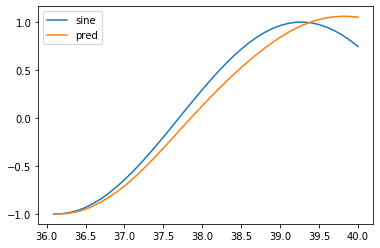

In [40]:
test.plot()

### Les use early stopping and validation data to prevent overtraining

In [41]:
stop = EarlyStopping(monitor="val_loss", patience=4)

### Need to create a validation Generator
-  problem is that the validation generator is looking at the same length of the test set 
- what needs to hapen is that the scaled test must be greater then the lenth chosen cannot be the same size
- Cannot have the start index + length == to 50wne the ense index is one short -> mesning we are missing the singular future predicted y point
- So we need to shorten the length -> must be one short of thetest point or you will be missing the predicted point

In [150]:
length = 30

In [151]:
generator = TimeseriesGenerator (
    train_scaled,
    train_scaled,
    length = length,
    batch_size=batch
)

In [152]:
val_generator = TimeseriesGenerator(
     test_scaled,
    test_scaled,
    length = length,
    batch_size=batch
)

In [153]:
from tensorflow.keras.layers import LSTM

In [154]:
model = Sequential()
model.add(LSTM(units = 30, input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam")

In [101]:
model.fit_generator(generator, validation_data= val_generator , epochs=4, callbacks=[stop])

Epoch 1/4
330/330 [==============================] - 277s 840ms/step - loss: 0.0226 - val_loss: 2.0251e-04
Epoch 2/4
330/330 [==============================] - 258s 783ms/step - loss: 1.3277e-04 - val_loss: 3.2385e-04
Epoch 3/4
330/330 [==============================] - 270s 817ms/step - loss: 1.2915e-04 - val_loss: 9.3349e-06
Epoch 4/4
330/330 [==============================] - 274s 831ms/step - loss: 1.2706e-04 - val_loss: 3.8937e-05


In [163]:
test_predictions = []
batch = train_scaled[-length:]
batch_reshaped = batch.reshape(1,length, n_features)
for i in range(len(test)):
    pred = model.predict(batch_reshaped)[0]
    test_predictions.append(pred)
    batch_reshaped = np.append(batch_reshaped[:,1:,:], [[pred]], axis = 1)

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


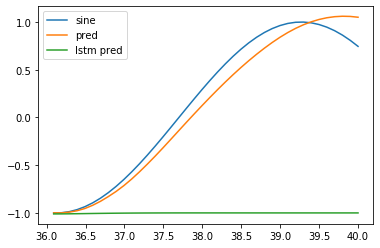

In [164]:
true_pred = scalar.inverse_transform(test_predictions)
test["lstm pred"] = true_pred
test.plot()

### Forecast this into the future
- We will retrain on all of the data
- We will scale the entire dats set

In [165]:
full_scalar = MinMaxScaler()
data_scaled = full_scalar.fit_transform(df)

In [166]:
funn_gen = TimeseriesGenerator(data_scaled,data_scaled, length=40, batch_size=batch)

In [167]:
len(df)

400

In [168]:
data_scaled.shape

(400, 1)

In [169]:
model = Sequential()
model.add(LSTM(units = 30, input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam")

In [170]:
model.fit_generator(funn_gen, epochs=2)

TypeError: only integer scalar arrays can be converted to a scalar index